In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from utils import load_mnist
from trainer import Trainer

In [9]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size': 256,
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)

print(config)

Namespace(batch_size=256, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


In [4]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1)
        
    plt.imshow(x, cmap='gray')
    plt.show()

In [5]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

# Shuffle dataset to split into train/valid set.
indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
    train_x,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)
train_y, valid_y = torch.index_select(
    train_y,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)

print('Train:', train_x.shape, train_y.shape)
print('Valid:', valid_x.shape, valid_y.shape)
print('Test:', test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [6]:
from model import Autoencoder

In [7]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [10]:
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss=7.1154e-02  valid_loss=4.8841e-02  lowest_loss=4.8841e-02
Epoch(2/50): train_loss=4.7147e-02  valid_loss=4.5461e-02  lowest_loss=4.5461e-02
Epoch(3/50): train_loss=4.4966e-02  valid_loss=4.3608e-02  lowest_loss=4.3608e-02
Epoch(4/50): train_loss=4.3555e-02  valid_loss=4.3014e-02  lowest_loss=4.3014e-02
Epoch(5/50): train_loss=4.2772e-02  valid_loss=4.1736e-02  lowest_loss=4.1736e-02
Epoch(6/50): train_loss=4.2232e-02  valid_loss=4.0871e-02  lowest_loss=4.0871e-02
Epoch(7/50): train_loss=4.1606e-02  valid_loss=4.1202e-02  lowest_loss=4.0871e-02
Epoch(8/50): train_loss=4.1252e-02  valid_loss=3.9688e-02  lowest_loss=3.9688e-02
Epoch(9/50): train_loss=4.0828e-02  valid_loss=3.9830e-02  lowest_loss=3.9688e-02
Epoch(10/50): train_loss=4.0512e-02  valid_loss=3.9721e-02  lowest_loss=3.9688e-02
Epoch(11/50): train_loss=4.0134e-02  valid_loss=3.9580e-02  lowest_loss=3.9580e-02
Epoch(12/50): train_loss=3.9861e-02  valid_loss=3.9930e-02  lowest_loss=3.9580e-02
Epoch(13/50):

# Test

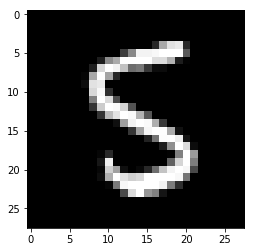

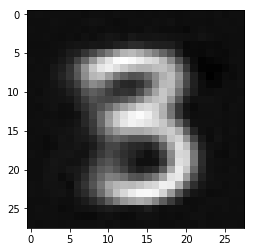

In [31]:
with torch.no_grad():
    import random
    
    index = int(random.random() * test_x.size(0))
    
    recon = model(test_x[index].view(1, -1)).squeeze()
    
    show_image(test_x[index])
    show_image(recon)

# Latent Space

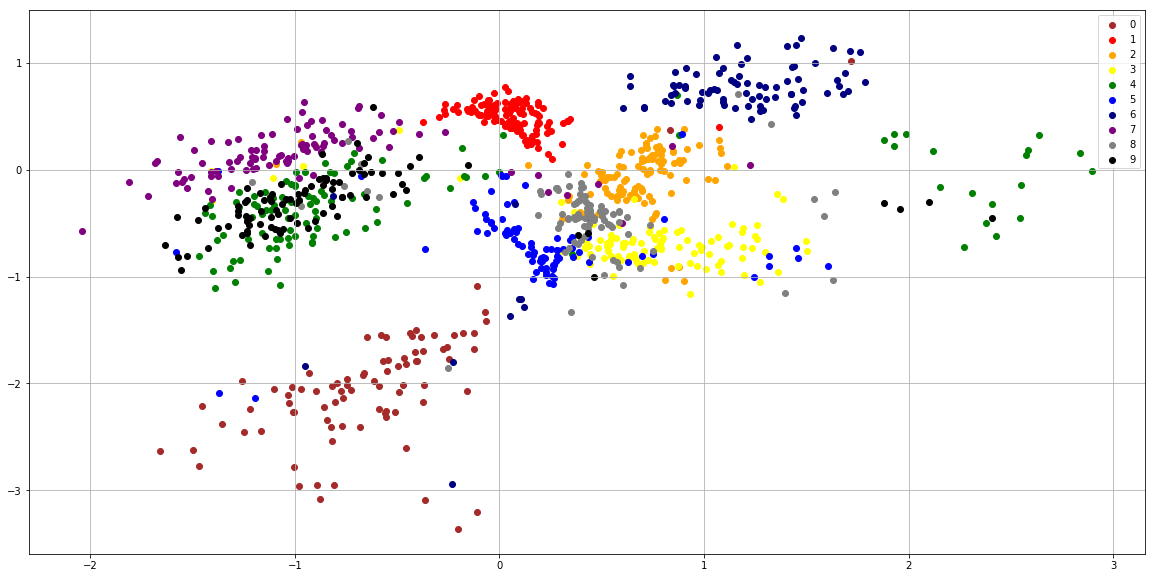

In [33]:
if config.btl_size == 2:
    color_map = [
        'brown', 'red', 'orange', 'yellow', 'green', 
        'blue', 'navy', 'purple', 'gray', 'black',
    ]
    
    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        latents = model.encoder(test_x[:1000])
        
        for i in range(10):
            target_latents = latents[test_y[:1000] == i]
            target_y = test_y[:1000][test_y[:1000] == i]
            plt.scatter(target_latents[:, 0],
                        target_latents[:, 1],
                        marker='o',
                        color=color_map[i],
                        label=i)
        plt.legend()
        plt.grid(axis='both')
        plt.show()

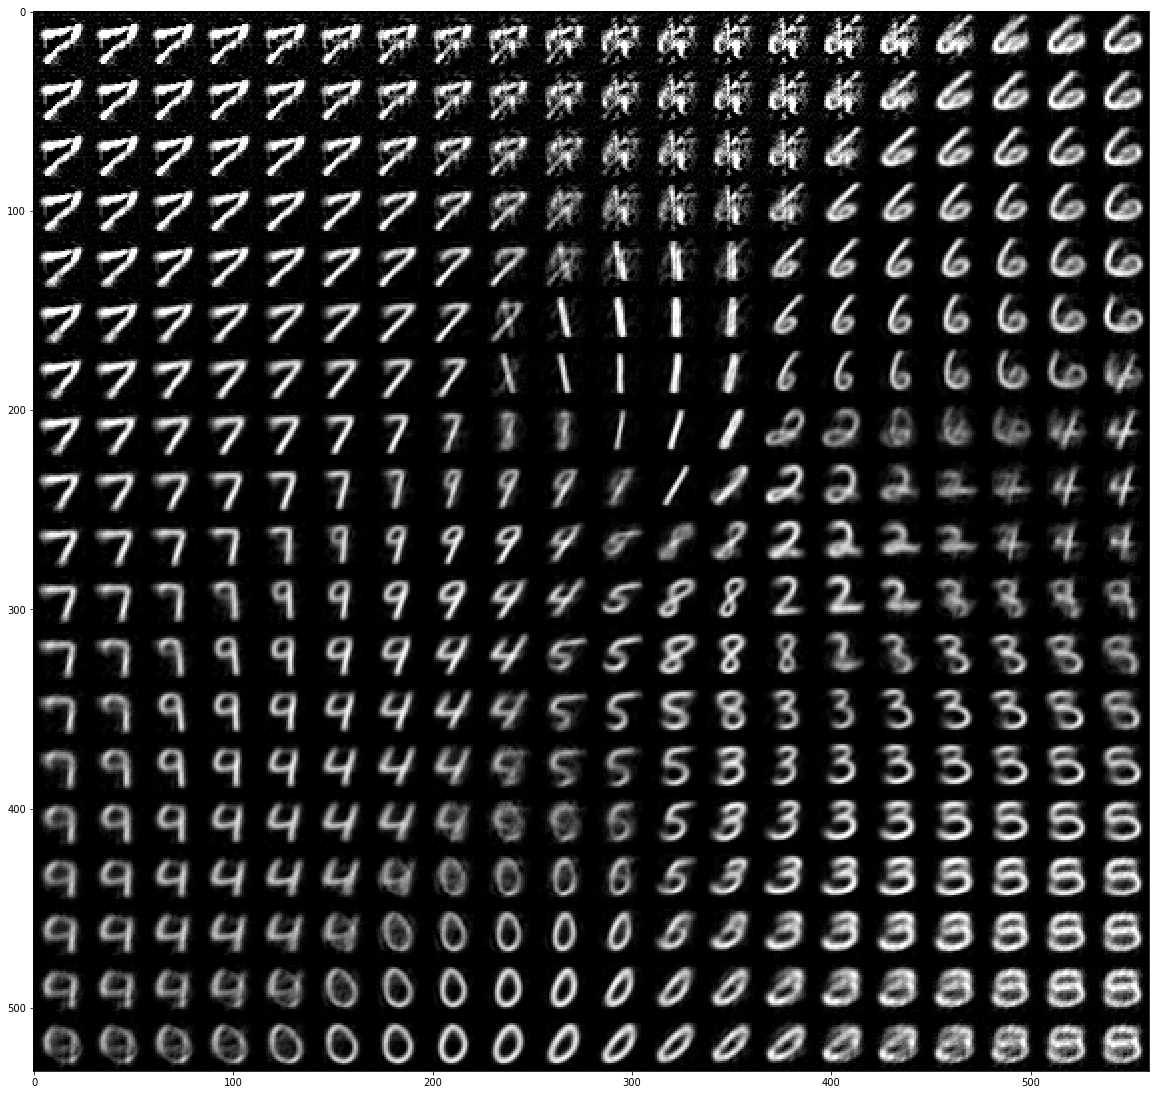

In [36]:
if config.btl_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []
        
        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,
                                                          max_range, step)]),
            ], dim=-1)
            
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            lines += [line]
            
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)